In [1]:
import pandas as pd
import numpy as np

In [5]:
data = pd.read_csv('house-prices-advanced/train.csv', index_col=0)
test_main = pd.read_csv('house-prices-advanced/test.csv', index_col=0)

In [52]:
test.shape
data.shape

(1460, 80)

LogSalePrice = data.SalePrice.apply(lambda x: np.log(x))
data.SalePrice.hist(bins=21)

In [3]:
# [c for c in data if  == object]
cat_feat = list(data.dtypes[data.dtypes == object].index)
# data[cat_feat] = data[cat_feat].fillna('nan')
# pd.get_dummies(data[cat_feat],)

In [37]:
data[cat_feat].nunique()

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [4]:
num_feat = [f for f in data if f not in (cat_feat + ['SalePrice'])]

In [6]:
dummy_train = pd.get_dummies(data[cat_feat],)
dummy_test = pd.get_dummies(test[cat_feat],)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test  = dummy_test[dummy_cols]

X = pd.concat([data[num_feat].fillna(-999), dummy_train], axis = 1)
y = data.SalePrice
test = pd.concat([test_main[num_feat].fillna(-999), dummy_test], axis = 1)

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import SCORERS

In [108]:
kfold = KFold(shuffle=True, n_splits=10, random_state=21)
params = {'max_depth': np.arange(5,25),
         'min_samples_leaf': np.arange(1,40,5),
         'random_state': [21]
         }
grid_search = GridSearchCV(DecisionTreeRegressor(), params, scoring = 'neg_mean_squared_log_error', 
                           cv = kfold, n_jobs=-1)
grid_search.fit(X, y)
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')[:3]

In [110]:
predicted = grid_search.best_estimator_.predict(test)
submit = pd.DataFrame(predicted, index = test.index, columns = ['SalePrice']).\
            to_csv('submission_house_prices_decision_tree.csv', header = True) 
#score = 0.19807, position = 3332, no matter the best parameters

#### Random Forest

In [132]:
kfold = KFold(shuffle=True, n_splits=5, random_state=21)
params = {'n_estimators': [1000],
         'max_depth': [10],
         'min_samples_leaf': [3],
         'max_features': [0.5],
         'random_state': [21]
         }
grid_search_rf = GridSearchCV(RandomForestRegressor(), params, scoring = 'neg_mean_squared_log_error', 
                           cv = kfold, n_jobs=-1)
grid_search_rf.fit(X, y)


pd.DataFrame(grid_search_rf.cv_results_).sort_values('rank_test_score')[:3]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.611683,0.155916,0.104038,0.01753,10,0.5,3,1000,21,"{'max_depth': 10, 'max_features': 0.5, 'min_sa...",-0.02197,-0.029403,-0.019678,-0.016361,-0.018052,-0.021093,0.004549,1


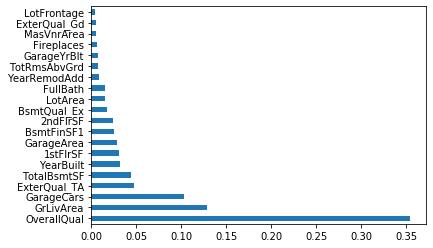

In [148]:
imp = pd.Series(grid_search_rf.best_estimator_.feature_importances_, index=X.columns)
imp.sort_values(ascending=False).iloc[:20].plot(kind='barh')

In [133]:
rf_preds_train = grid_search_rf.predict(X)

In [128]:
predicted_rf = grid_search_rf.best_estimator_.predict(test)
submit = pd.DataFrame(predicted_rf, index = test.index, columns = ['SalePrice']).\
            to_csv('submission_house_prices_rf.csv', header = True)
# 0.14706 pos. 2238

#### Extremely Randomized Trees

In [131]:
from sklearn.ensemble import ExtraTreesRegressor

kfold = KFold(shuffle=True, n_splits=5, random_state=21)

params = {'n_estimators': [1000],
         'max_depth': [10],
         'min_samples_leaf': [3],
         'max_features': [0.5],
         'random_state': [21]
         }
grid_search_ert = GridSearchCV(ExtraTreesRegressor(), params, scoring = 'neg_mean_squared_log_error', 
                           cv = kfold, n_jobs=-1)
grid_search_ert.fit(X, y)

# rf_preds_train = grid_search_rf.predict(y)
pd.DataFrame(grid_search_ert.cv_results_).sort_values('rank_test_score')[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.442355,0.075702,0.115083,0.008311,10,0.5,3,1000,21,"{'max_depth': 10, 'max_features': 0.5, 'min_sa...",-0.022636,-0.030654,-0.019542,-0.017784,-0.019662,-0.022056,0.004573,1


#### Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

In [27]:
from sklearn.preprocessing import StandardScaler

train_median = data[num_feat].median()

X_lin = pd.concat([data[num_feat].fillna(train_median),
                     data[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

test_lin = pd.concat([test_main[num_feat].fillna(train_median),
                     test_main[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

# X_lin.apply(lambda x: np.log(x+1))
scaler = StandardScaler()
scaler.fit(X_lin[num_feat])

X_lin[num_feat] = scaler.transform(X_lin[num_feat])
# y_lin = np.log(y)
test_lin[num_feat] = scaler.transform(test_lin[num_feat])

In [55]:
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import ElasticNetCV

lr = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=21)
lin_predictions = lr.fit(X_lin,y).predict(X_lin)
mean_squared_log_error(y, lin_predictions)**0.5


0.12905784174532703

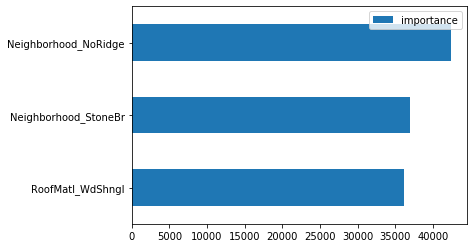

In [86]:
pd.DataFrame(lr.coef_, index = X_lin.columns, columns = ['importance']).sort_values(by='importance')[-3:].plot(kind='barh')

In [58]:
predicted = lr.predict(test_lin)
submit = pd.DataFrame(predicted, index = test_lin.index, columns = ['SalePrice']).\
            to_csv('submission_house_prices_lasso.csv', header = True)
# 0.139 pos. 1891

#### Linear Regression with log transform

In [88]:
from sklearn.metrics import mean_squared_error
X_lin = pd.concat([data[num_feat].fillna(train_median),
                     data[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

test_lin = pd.concat([test_main[num_feat].fillna(train_median),
                     test_main[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

X_lin = np.log1p(X_lin)
y_log = np.log1p(y)
test_log = np.log1p(test_lin)

lr_log = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=21)
lin_predictions = lr_log.fit(X_lin,y_log).predict(X_lin)
mean_squared_error(y_log, lin_predictions)**0.5

0.11424048129488253

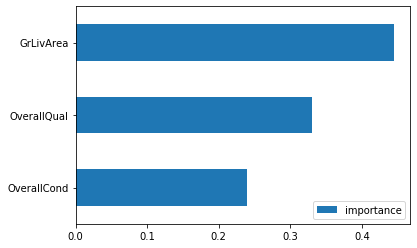

In [89]:
pd.DataFrame(lr_log.coef_, index = X_lin.columns, columns = ['importance']).sort_values(by='importance')[-3:].plot(kind='barh')

In [93]:
predicted = np.expm1(lr_log.predict(test_log))
submit = pd.DataFrame(predicted, index = test_lin.index, columns = ['SalePrice']).\
            to_csv('submission_house_prices_lasso.csv', header = True)
# 0.12245 pos. 894

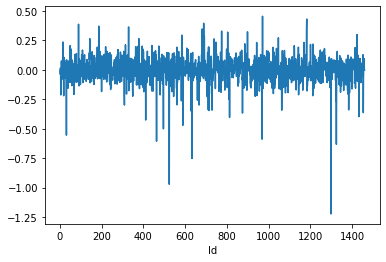

In [106]:
errors.plot()

In [122]:
errors = y_log-lin_predictions
errors[abs(errors) > 0.5].index.to_list()

[31, 463, 496, 524, 633, 969, 1299, 1325]

In [125]:
X_lin_cleaned = X_lin.drop(errors[abs(errors) > 0.5].index.to_list())
y_log_clean = y_log.drop(errors[abs(errors) > 0.5].index.to_list())

lr_log_clean = ElasticNetCV(l1_ratio=1, cv=5, random_state=21)
lin_predictions_clean = lr_log_clean.fit(X_lin_cleaned,y_log_clean).predict(X_lin_cleaned)
mean_squared_error(y_log_clean, lin_predictions_clean)**0.5

0.09662500459052618

In [126]:
predicted = np.expm1(lr_log_clean.predict(test_log))
submit = pd.DataFrame(predicted, index = test_lin.index, columns = ['SalePrice']).\
            to_csv('submission_house_prices_lasso.csv', header = True)
# 0.12039 pos. 741

#### SVM regression

In [183]:
from sklearn.svm import LinearSVR
kfold = KFold(shuffle=True, n_splits=5, random_state=21)

# (-cross_val_score(LinearSVR(C=0.1, max_iter = 50000, random_state=21), X_lin_cleaned, y_log_clean, 
#                   scoring = 'neg_mean_squared_error', cv = kfold, n_jobs=-1).mean())**0.5



SVR_log_clean = LinearSVR(C=0.1, random_state=21, max_iter=100000)
lin_predictions_SVR = SVR_log_clean.fit(X_lin_cleaned,y_log_clean).predict(X_lin_cleaned)
mean_squared_error(y_log_clean, lin_predictions_SVR)**0.5

0.09129135289519168

In [191]:
predicted_SVR = np.expm1(SVR_log_clean.predict(test_log))
submit = pd.DataFrame(predicted_SVR, index = test_lin.index, columns = ['SalePrice']).\
            to_csv('submission_house_prices_SVR.csv', header = True)
# 0.12055 pos. 741

#### add meta feature from SVR and ElasticNet 

In [202]:

X_lin_cleaned_meta = pd.DataFrame(np.stack([lin_predictions_clean, lin_predictions_SVR], axis = 1), 
                                           index=X_lin_cleaned.index, columns = ['lr', 'SVR'])
test_meta = pd.DataFrame(np.stack([predicted, predicted_SVR], axis = 1), 
                                           index=test.index, columns = ['lr', 'SVR'])
y_clean = np.expm1(y_log_clean)

lr_clean_meta = ElasticNetCV(l1_ratio=1, cv=5, random_state=21)
lr_clean_meta.fit(X_lin_cleaned_meta, y_clean)
lin_predictions_clean_meta = lr_clean_meta.predict(X_lin_cleaned_meta)
mean_squared_error(y_clean, lin_predictions_clean_meta)**0.5

30228.438568048135

In [204]:
predicted_meta = lr_clean_meta.predict(test_meta)
submit = pd.DataFrame(predicted_meta, index = test_meta.index, columns = ['SalePrice']).\
            to_csv('submission_house_prices_lr_meta.csv', header = True)
# 0.12055 pos. 741